In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("m_sand_concrete_dataset.csv")
df

,Cement,M_sand,Fly_ash,W_B_ratio,Water_reducer,Gravel,Compressive_strength,CPC
0,404.791210,716.707805,25.596509,0.319968,3.913121,1278.338629,228.661746,162.619943
1,337.775688,638.563169,93.604357,0.478330,3.975574,1231.632520,193.437545,154.611738
2,421.719584,548.381534,16.460782,0.343852,4.730135,1209.436235,205.165174,148.979534
3,389.473606,650.313433,4.491062,0.547399,1.266917,1251.394066,189.348505,160.160457
4,268.835470,545.693631,43.509706,0.393100,2.950379,1012.045390,154.693854,132.971430
...,...,...,...,...,...,...,...,...
81,331.277372,742.475442,24.783956,0.580782,4.007409,1252.597963,208.001125,157.217033
82,412.804077,595.141668,23.666236,0.341222,1.192764,1016.670375,201.796756,139.879017
83,283.394584,785.869819,74.601428,0.587664,4.247044,1084.183431,191.573191,148.668242
84,254.542415,587.275351,81.656876,0.540265,0.286160,1100.239012,165.576196,130.780271


In [5]:
df = df.copy()
X_features = df.drop(columns=["Compressive_strength", "CPC"])
outlier_pred = iso.fit_predict(X_features)

df_clean = df[outlier_pred == 1].reset_index(drop=True)
print("Shape original:", df.shape)
print("Shape after remove outlier:", df_clean.shape)

Shape original: (86, 8)
Shape after remove outlier: (77, 8)


In [43]:
X = df_clean.iloc[:, :6].values   # feature
y = df_clean.iloc[:, 6:].values   # label

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [151]:
from sklearn.svm import SVR

svr_base = SVR(kernel='rbf')
multi_svr = MultiOutputRegressor(svr_base)

param_dist = {
    "estimator__C": [1, 10, 50, 100, 150],
    "estimator__epsilon": [0.01, 0.05, 0.1, 0.2]
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=multi_svr,
    param_distributions=param_dist,
    n_iter=20,
    cv=kf,
    scoring="r2",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

In [152]:
search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print("Best CV R²:", search.best_score_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best params: {'estimator__epsilon': 0.01, 'estimator__C': 150}
Best CV R²: 0.660110086713128


In [153]:
search.best_estimator_

,estimator,"SVR(C=150, epsilon=0.01)"
,n_jobs,None
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,150
,epsilon,0.01
,shrinking,True
,cache_size,200


In [154]:
def calc_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return r2, rmse
    
y_pred_train = search.predict(X_train)
y_pred_test = search.predict(X_test)

# CS
r2_cs_train, rmse_cs_train = calc_metrics(y_train[:,0], y_pred_train[:,0])
r2_cs_test,  rmse_cs_test  = calc_metrics(y_test[:,0],  y_pred_test[:,0])

# CPC
r2_cpc_train, rmse_cpc_train = calc_metrics(y_train[:,1], y_pred_train[:,1])
r2_cpc_test,  rmse_cpc_test  = calc_metrics(y_test[:,1],  y_pred_test[:,1])

print("Train:")
print(f"CS  - R²: {r2_cs_train:.3f}, RMSE: {rmse_cs_train:.3f}")
print(f"CPC - R²: {r2_cpc_train:.3f}, RMSE: {rmse_cpc_train:.3f}")

print("Test:")
print(f"CS  - R²: {r2_cs_test:.3f}, RMSE: {rmse_cs_test:.3f}")
print(f"CPC - R²: {r2_cpc_test:.3f}, RMSE: {rmse_cpc_test:.3f}")

Train:
CS  - R²: 0.846, RMSE: 5.991
CPC - R²: 0.873, RMSE: 3.001
Test:
CS  - R²: 0.864, RMSE: 8.171
CPC - R²: 0.896, RMSE: 2.813


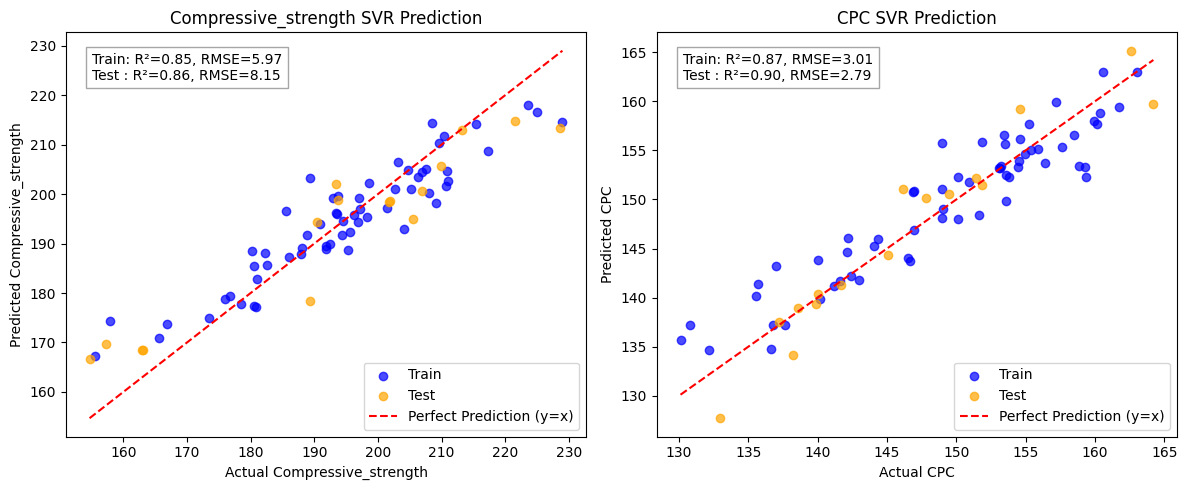

In [149]:
plt.figure(figsize=(12,5))

# Compressive Strength
plt.subplot(1,2,1)
plt.scatter(y_train[:,0], y_pred_train[:,0], alpha=0.7, color="blue", label="Train")
plt.scatter(y_test[:,0], y_pred_test[:,0], alpha=0.7, color="orange", label="Test")
plt.plot([min(y_train[:,0].min(), y_test[:,0].min()),
          max(y_train[:,0].max(), y_test[:,0].max())],
         [min(y_train[:,0].min(), y_test[:,0].min()),
          max(y_train[:,0].max(), y_test[:,0].max())],
         'r--', label="Perfect Prediction (y=x)")
plt.text(0.05, 0.95,
         f"Train: R²={r2_cs_train:.2f}, RMSE={rmse_cs_train:.2f}\n"
         f"Test : R²={r2_cs_test:.2f}, RMSE={rmse_cs_test:.2f}",
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
plt.xlabel("Actual Compressive_strength")
plt.ylabel("Predicted Compressive_strength")
plt.title("Compressive_strength SVR Prediction")
plt.legend()

# CPC
plt.subplot(1,2,2)
plt.scatter(y_train[:,1], y_pred_train[:,1], alpha=0.7, color="blue", label="Train")
plt.scatter(y_test[:,1], y_pred_test[:,1], alpha=0.7, color="orange", label="Test")
plt.plot([min(y_train[:,1].min(), y_test[:,1].min()),
          max(y_train[:,1].max(), y_test[:,1].max())],
         [min(y_train[:,1].min(), y_test[:,1].min()),
          max(y_train[:,1].max(), y_test[:,1].max())],
         'r--', label="Perfect Prediction (y=x)")
plt.text(0.05, 0.95,
         f"Train: R²={r2_cpc_train:.2f}, RMSE={rmse_cpc_train:.2f}\n"
         f"Test : R²={r2_cpc_test:.2f}, RMSE={rmse_cpc_test:.2f}",
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
plt.xlabel("Actual CPC")
plt.ylabel("Predicted CPC")
plt.title("CPC SVR Prediction")
plt.legend()

plt.tight_layout()
plt.show()

In [156]:
import pickle
with open("best_SVR_model.pkl", "wb") as f:
    pickle.dump(search.best_estimator_, f)

# with open("best_xgb_model.pkl", "rb") as f:
#     loaded_model = pickle.load(f)